# AOC 2023

https://adventofcode.com/2023

In [3]:
from typing import List, Tuple
from matplotlib import pyplot as plt
from collections import Counter, abc, deque
from functools import reduce, cached_property
from ast import literal_eval
import re

In [4]:
%matplotlib inline

## Utils

In [21]:
class Parser:
    @staticmethod
    def _read_file(filename, pp) -> List[str]:
        return [pp(l.strip()) for l in open(filename, "r")]

    @staticmethod
    def _read_test_input(string, pp) -> List[str]:
        return [pp(l.strip()) for l in string.split("\n") if len(l.strip()) > 0]
    
    def parse_input(input_str, pp=lambda x: x):
        if input_str.endswith(".txt"):
            return Parser._read_file(input_str, pp)
        else:
            return Parser._read_test_input(input_str, pp)
                                                                
class Grid(abc.Mapping):
    """
        2D-grid keyed by (row, col) and value is content
    """
    def __init__(self, lines: List[str]):
        self._grid = {(r, c): v.strip()
                        for r, line in enumerate(lines)
                        for c, v in enumerate(line)}
        self.directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        self.n_cols = len(lines[0])
        self.n_rows = len(lines)

    def valid(self, point):
        r, c = point
        return  (r >= 0 and r < (self.n_rows) and
                 c >= 0 and c < (self.n_cols))

    def __getitem__(self, point):
        return self._grid[point[0], point[1]]

    def __iter__(self):
        return iter(self._grid)

    def __len__(self):
        return self.n_rows * self.n_cols
        
    def neighbors(self, cell):
        r, c = cell
        return [
            ((r + rd), (c + cd))
            for rd, cd in self.directions
                if self.valid(((r + rd), (c + cd)))
        ]

## Day 1
    

### Part 1

Find the first and last digit.

In [82]:
def d1p1(input_str):
    input = Parser.parse_input(input_str)
    first, last = None, None
    def find_digit(line):
        for c in line:
            if c.isdigit():
                return c
        return None

    results = []
    for line in input:
        first, last = find_digit(line), find_digit(line[::-1])
        results.append(int(first + last))
        
    return sum(results)

In [83]:
sample_str = """
            1abc2
            pqr3stu8vwx
            a1b2c3d4e5f
            treb7uchet
            """

assert d1p1(sample_str) == 142
d1p1("data/day1.txt")

54644

### Part 2

Since we know that digit names are of length 3, 4, or 5 - we can check if a length k digit name matches from a given index. Do this if its not already a digit.

In [85]:
s2d = {
    "one": "1",
    "two": "2",
    "three": "3",
    "four": "4",
    "five": "5",
    "six": "6",
    "seven": "7",
    "eight": "8",
    "nine": "9"
}
s2d_rev = {k[::-1]: v for k, v in s2d.items()}

def valid_digitname(str, start, valid_s2d):
    # Is there a valid digitname from start index in the input string
    
    ends = [3, 4, 5]
    # Possible lengths for valid digit names
    ends = [3, 4, 5]
    for e in ends:
        candidate_name = str[start: start+e]
        if candidate_name in valid_s2d:
            return valid_s2d[candidate_name]
    return None

def find_digit(line, valid_s2d):
        for i in range(0, len(line), 1):
            c = line[i]
            if c.isdigit():
                return c
            elif (d := valid_digitname(line, i, valid_s2d)):
                return d
        return None

def d1p2(input_str):
    input = Parser.parse_input(input_str)
    results = []
    for line in input:
        first = find_digit(line, s2d)
        last = find_digit(line[::-1], s2d_rev)
        results.append(int(first + last))
        
    return sum(results)

In [86]:
sample_str = """
    two1nine
    eightwothree
    abcone2threexyz
    xtwone3four
    4nineeightseven2
    zoneight234
    7pqrstsixteen
"""

assert d1p2(sample_str) == 281
d1p2("data/day1.txt")

53348

## Day 2

### Part 1

This seems like a form of CSP. We have some predicate (valid cubes), for each line - check if it satisfies the predicate.

In [87]:
sample_str = """
    Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green
    Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue
    Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red
    Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red
    Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green
"""

def parse_line(line):
    game, rest = line.split(":")
    game_id = int(game.replace("Game ", "").strip())
    
    games = []
    for g in rest.split(";"):
        counts = Counter()
        for hand in g.split(","):
            n, color = hand.strip().split(" ")
            counts[color.strip()] += int(n.strip())
            
        games.append(counts)
    return game_id, games

In [91]:
total_cubes = {"red": 12, "green": 13, "blue": 14}
valid_hand = lambda picked: (picked["red"] <= total_cubes["red"] and
    picked["green"] <= total_cubes["green"] and 
    picked["blue"] <= total_cubes["blue"])

def d2p1(input_str):
    input = Parser.parse_input(input_str, pp=parse_line)
    valid_ids = []
    for game_id, game in input:
        if all([valid_hand(hand) for hand in game]):
            valid_ids.append(game_id)

    return sum(valid_ids)

In [92]:
sample_str = """
    Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green
    Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue
    Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red
    Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red
    Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green
"""

assert d2p1(sample_str) == 8
d2p1("data/day2.txt")

2551

### Part 2

In [93]:
def update_min_cubes(candidate, best):
    for c in ["red", "green", "blue"]:
        best[c] = max(candidate[c], best[c])

def game_power(hand):
    return hand["red"] * hand["blue"] * hand["green"]

def d2p2(input_str):
    input = Parser.parse_input(input_str, pp=parse_line)
    powers = []
    for game_id, game in input:
        min_cubes = {"red": 0, "blue": 0, "green": 0}
        for hand in game:
            update_min_cubes(hand, min_cubes)
        powers.append(game_power(min_cubes))
        
    return sum(powers)

In [94]:
sample_str = """
    Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green
    Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue
    Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red
    Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red
    Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green
"""

assert d2p2(sample_str) == 2286
d2p2("data/day2.txt")

62811

## Day 3

### Part 1

The basic idea for this part is:

- For every symbol, see if you can find a neighbor digit.
    - If yes, expand left and right to find the full number
    - Mark the indexes that contain the number and don't double count


In [96]:
def expand_to_number(point, grid):
    # Expand index left and right to find the number
    s = e = point[1]
    while (s >= 0):
        v_s = grid.get((point[0], s - 1), "")
        if (v_s.isdigit()):
            s -= 1
        else:
            break

    while (e < grid.n_cols):
        v_e = grid.get((point[0], e + 1), "")
        if (v_e.isdigit()):
            e += 1
        else:
            break
    return (s, e)    

def d3p1(input_str):
    input = Parser.parse_input(input_str)
    grid = Grid(input)
    seen = set()
    parts = []
    symbol_points = [p for p in grid if not grid.get(p).isdigit() and grid.get(p) != "."]
    
    for p in symbol_points:
        neighbors = grid.neighbors(p)
        for n in neighbors:
            if (n not in seen) and (grid.get(n)).isdigit():
                left, right = expand_to_number(n, grid)
                digits = []
                for i in range(left, right+1):
                    p = (n[0], i)
                    seen.add(p)
                    digits.append(grid.get(p))
                parts.append(int("".join(digits)))
    return sum(parts)

In [112]:
sample_str = """
    467..114..
    ...*......
    ..35..633.
    ......#...
    617*......
    .....+.58.
    ..592.....
    ......755.
    ...$.*....
    .664.598..
"""

assert d3p1(sample_str) == 4361
d3p1("data/day3.txt")

540025

### Part 2

Similar idea - find gears and multiply. Duplicates don't matter. Handle double counting of neighbors per gear.

In [113]:
def get_gear_ratio(p, grid):
    digit_neighbors = [n for n in grid.neighbors(p) if grid.get(n).isdigit()]
    
    # Prevents double counting of neighbors
    seen = set({})
    parts = []
    
    # Find all numbers surrounding gear.
    for n in digit_neighbors:
        if n in seen:
            continue
            
        digits = []            
        left, right = expand_to_number(n, grid)
        for i in range(left, right+1):
            p = (n[0], i)
            digits.append(grid.get(p))
            seen.add(p)
        
        parts.append(int("".join(digits)))
        
    return parts[0] * parts[1] if len(parts) == 2 else None

def d3p2(input_str):
    input = Parser.parse_input(input_str)
    grid = Grid(input)
    gear_ratios = []
    possible_gears = [p for p in grid if grid.get(p) == "*"]

    for p in possible_gears:
        if (r := get_gear_ratio(p, grid)) is not None:
            gear_ratios.append(r)
            
    return sum(gear_ratios)

In [115]:
assert d3p2(sample_str) == 467835
d3p2("data/day3.txt")

84584891

## Day 4

### Part 1

There is some ambiguity on whether numbers can be repeated or not.
- Let's assume the winning list and list of numbers on hand are unique. i.e You can only win once with a given number.

In [117]:
def parse_line(line) -> Tuple[List[int], List[int]]:
    card_name, numbers = line.split(":")
    left, right = numbers.split("|")
    winners = [int(i.strip()) for i in left.strip().split(" ") if len(i.strip()) > 0]
    hand = [int(i.strip()) for i in right.strip().split(" ") if len(i.strip()) > 0]
    card_num = int(card_name.replace("Card ", ""))
    
    return card_num, winners, hand

In [125]:
def d4p1(input_str):
    input = Parser.parse_input(input_str, pp=parse_line)
    score = 0
    for _, winning, hand in input:
        n_wins = len(set(winning) & set(hand))
        score += 2**(n_wins - 1) if n_wins > 0 else 0
        
    return score

In [126]:
sample_str = """
Card 1: 41 48 83 86 17 | 83 86  6 31 17  9 48 53
Card 2: 13 32 20 16 61 | 61 30 68 82 17 32 24 19
Card 3:  1 21 53 59 44 | 69 82 63 72 16 21 14  1
Card 4: 41 92 73 84 69 | 59 84 76 51 58  5 54 83
Card 5: 87 83 26 28 32 | 88 30 70 12 93 22 82 36
Card 6: 31 18 13 56 72 | 74 77 10 23 35 67 36 11
"""

assert d4p1(sample_str) == 13
d4p1("data/day4.txt")

23750

### Part 2

The key idea here is how it terminates. You only have to walk the sorted game list once  - since a winning hand will only create copies of _subsequent_ ids.
The number of cards that we'll have to process in a future step can change based on current step. But past steps will not change. 

In [130]:
def get_copies(num_wins, curr_id, curr_id_copies):
    ids = list(range(curr_id + 1, curr_id + num_wins + 1))
    
    return Counter({id: curr_id_copies for id in ids})
    
def d4p2(input_str):
    input = Parser.parse_input(input_str, pp=parse_line)
    games = {c_num: (winning, hand) for c_num, winning, hand in input}
    ids = sorted(games.keys())
    # Initialize with one copy each
    next_id_counts = Counter(list(games.keys()))
    
    for id in ids:
        winning, hand = games[id]
        n_wins = len(set(winning) & set(hand))
        if n_wins > 0:
            next_id_counts.update(get_copies(n_wins, id, next_id_counts[id]))
            
    return next_id_counts.total()

In [131]:
assert d4p2(sample_str) == 30
d4p2("data/day4.txt")

13261850

## Day 5

### Part 1

This one is fun. Basically we are given a bunch of constraints mapping sources to destinations. Goal is to compose them for a result. Knowing AOC, we can't expand "ranges" out to lists for efficiency. Should instead create some abstraction to allow operations in ranges. 

In [145]:
sample_str = """
seeds: 79 14 55 13

seed-to-soil map:
50 98 2
52 50 48

soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15

fertilizer-to-water map:
49 53 8
0 11 42
42 0 7
57 7 4

water-to-light map:
88 18 7
18 25 70

light-to-temperature map:
45 77 23
81 45 19
68 64 13

temperature-to-humidity map:
0 69 1
1 0 69

humidity-to-location map:
60 56 37
56 93 4
"""

In [146]:
def map_from_lines(start_line, sample_input):
    i = start_line
    s2d_map = S2DMap()

    while (i < len(sample_input) and sample_input[i] != "" and not re.match(".*map:", sample_input[i])):
        vals = [int(j) for j in sample_input[i].strip().split(" ")]
        s2d_map.add(vals[1], vals[0], vals[2])
        i += 1
    
    return i, s2d_map   
    
class S2DMap:
    def __init__(self):
        self.maps = []

    def add(self, source, dest, count):
        self.maps.append((source, dest, count))
                         
    def get(self, key):
        for source, dest, count in self.maps:
            if key >= source and key < source + count:
                return dest + (key - source)
                
        return key

    def get_range(self, source_range):
        remaining = [source_range]
        to_range = lambda s, c: (s, s + count)
        results = []
        
        # Find overlap of source with this map
        for source, dest, count in self.maps:
            s_range = to_range(source, count)
            d_range = to_range(dest, count)
            to_dest = lambda r: (d_range[0] + (r[0] - s_range[0]), d_range[0] + (r[1] - s_range[0]))

            new_splits = []
            for r in remaining:
                match, no_matches = split_range(r, s_range) 
                results.append(to_dest(match)) if match else None
                new_splits += no_matches
            remaining = new_splits

        if len(remaining) > 0:
            # 1-1 default
            results += remaining
            
        return results
        
class FoodMap:
    def __init__(self, input_lines):
        self.parse_lines(input_lines)
        self.seed2loc_chain = [ 
            self.seed2soil,
            self.soil2fert,
            self.fert2water,
            self.water2light,
            self.light2temp,
            self.temp2humid,
            self.humid2loc
        ]

    def parse_lines(self, input):
        i = 0
        while i < len(input):
            if re.match("seeds: ", input[i]):
                self.seeds = [int(i) for i in input[i].split("seeds: ")[1].strip().split(" ")]
                i += 1
            elif re.match("seed-to-soil map:", input[i]):
                i, self.seed2soil = map_from_lines(i + 1, input)
            elif re.match("soil-to-fertilizer map:", input[i]):
                i, self.soil2fert = map_from_lines(i + 1, input)
            elif re.match("fertilizer-to-water map:", input[i]):
                i, self.fert2water = map_from_lines(i + 1, input)
            elif re.match("water-to-light map:", input[i]):
                i, self.water2light = map_from_lines(i + 1, input)
            elif re.match("light-to-temperature map:", input[i]):
                i, self.light2temp = map_from_lines(i + 1, input)
            elif re.match("temperature-to-humidity map:", input[i]):
                i, self.temp2humid = map_from_lines(i + 1, input)
            elif re.match("humidity-to-location map:", input[i]):
                i, self.humid2loc = map_from_lines(i + 1, input)
            else:
                i += 1
    
    def seed2loc(self, seed):
        return reduce(lambda source, s2d: s2d.get(source), self.seed2loc_chain, seed)
    
    def seed2locrange(self, seed_ranges):
        results = []
        for s in seed_ranges:
            ranges = [s]
            for s2d in self.seed2loc_chain:
                next_ranges = []
                for r in ranges:
                    next_ranges += s2d.get_range(r)
                ranges = next_ranges
            results += ranges
            
        return results

In [147]:
def split_range(r1: Tuple[int, int], r2: Tuple[int, int]) -> Tuple[Tuple[int, int],List[Tuple[int, int]]]:
    """
        Split r1 (Tuple[int, int]) into 2 parts
            - Overlapping with r2.
            - Not overlapping with r2 (List)
            - Assumes start inclusive/end exclusive tuples.
    """
    s1, e1 = r1
    s2, e2 = r2

    # Cases handled
    # ---r1---
    #      ---r2---
    overlap_and_left_r2 = s1 < s2 and e1 > s2 and e1 <= e2
    #  --r1----
    # ----r2-
    overlap_and_right_r2 = s1 >= s2 and s1 < e2 and e1 > e2
    #    --r1---
    # -----r2------
    inside_r2 = s1 >= s2 and e1 <= e2
    # ---r1---------
    #     ----r2--
    contains_r2 = s1 <= s2 and e1 > e2

    if overlap_and_left_r2:
        return ((s2, e1), [(s1, s2)])
    elif overlap_and_right_r2:
        return ((s1, e2), [(e2, e1)])
    elif inside_r2:
        return ((s1, e1), [])
    elif contains_r2:
        return ((s2, e2), [(s1, s2), (e2, e1)])
    
    return (None, [r1])

# Overlap and on left
assert split_range((2, 5), (3, 8)) == ((3, 5), [(2, 3)])
# Overlap and contained
assert split_range((2, 5), (1, 8)) == ((2, 5), [])
#  Overlap and on right
assert split_range((6, 12), (3, 8)) == ((6, 8), [(8, 12)])
# Overlap and contains
assert split_range((6, 12), (7, 10)) == ((7, 10), [(6, 7), (10, 12)])
# No overlap - smaller
assert split_range((79, 93), (98, 100)) == (None, [(79, 93)])
# No overlap - greater
assert split_range((101, 105), (98, 100)) == (None, [(101, 105)])

In [150]:
def d5p1(input_str):
    input = Parser.parse_input(input_str)
    food_map = FoodMap(input)

    return min([food_map.seed2loc(s) for s in food_map.seeds])

In [151]:
assert d5p1(sample_str) == 35
d5p1("data/day5.txt")

346433842

## Part 2

The source seeds are also ranges now. A seed range is represented as (start, count). We need to map this to a location. We only care about the lowest location number. I think this can be done by treating the seed range as an interval and doing interval matching.

Let's create a new function split_range that can split an interval into overlapping and non-overlapping parts.

With this we apply the following to every map

- Split source ranges into ones that overlap and don't overlap with destination. Then convert them to destination categories.
- Repeat for every map. 

In [154]:
def d5p2(input_str):
    input = Parser.parse_input(input_str)
    food_map = FoodMap(input)
    seed_ranges = [(food_map.seeds[i], food_map.seeds[i] + food_map.seeds[i + 1]) for i in range(0, len(food_map.seeds), 2)]

    return min(food_map.seed2locrange(seed_ranges), key=lambda x: x[0])[0]

In [155]:
assert d5p2(sample_str) == 46
d5p2("data/day5.txt")

60294664

# Day 6

In [16]:
def to_dict(lines):
    result = {}
    parse_val = lambda v: [int(i) for i in v.strip().split()]
    for line in lines:
        k, v = line.split(":")
        result[k.strip().lower()] = parse_val(v)
    
    return list(zip(result["time"], result["distance"]))
    
# sample_input, file_input = map(to_dict, )

### Part 1

We are given pairs of numbers, the total time and total distance to beat. We have to split the first number into a, b where a.b > second number. Given two positive numbers, the product is maximized when a, b are closest. This can be proved using the [AM-GM inequality](https://en.wikipedia.org/wiki/AM-GM_Inequality). Or we can solve the quadratic $a.(k - a) \ge d$. Take a derivative and set to 0. 

For fun, let's plot this to see what it looks like.

Text(0.5, 1.0, 'a.b for a + b = 50')

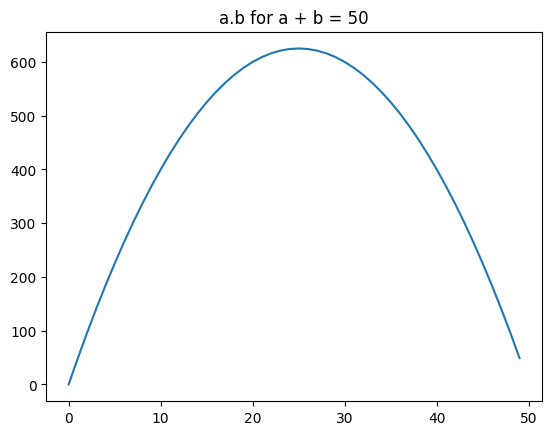

In [17]:
xs, ys = [], []
k = 50
for i in range(0, 50):
    ys.append(i * (k - i))
    xs.append(i)

ax = plt.subplot(111)
    
ax.plot(xs, ys)
ax.set_title(f"a.b for a + b = {k}")

As seen here, the product is maximum for the numbers around 25, 50 - 25. It falls for all other values.

We can use binary search to find the lowest start number that satisfies the product requirement.

In [24]:
def n_wins(t, d):
    start, end = 1, t
    last_valid = None
    
    # Find the lowest index that satisfies the i * t - i > d.
    # Then i can take values between (i, (t - i)) inclusive for product > d.
    while start <= end:
        mid = (start + end) // 2
        if (mid * (t - mid)) > d:
            last_valid = mid
            end = mid - 1
        else:
            start = mid + 1
        
    return abs((t - last_valid) - last_valid) + 1 if last_valid else 0


In [25]:
def d6p1(input_str):
    input = to_dict(Parser.parse_input(input_str))
    
    return reduce(lambda a, b: a * b, [n_wins(t, d) for t, d in input], 1)

In [26]:
sample_str = """
    Time:      7  15   30
    Distance:  9  40  200
"""

assert d6p1(sample_str) == 288
d6p1("data/day6.txt")

293046

### Part 2

This one just ensures our technique is efficient and not looking at all possible combinations. It sure is :)

In [27]:
def to_dict_2(lines):
    result = {}
    parse_val = lambda v: [int(v.replace(" ", ""))]
    for line in lines:
        k, v = line.split(":")
        result[k.strip().lower()] = parse_val(v)
    return list(zip(result["time"], result["distance"]))

In [28]:
def d6p2(input_str):
    input = to_dict_2(Parser.parse_input(input_str))
    
    return reduce(lambda a, b: a * b, [n_wins(t, d) for t, d in input], 1)

In [29]:
assert d6p2(sample_str) == 71503
d6p2("data/day6.txt")

35150181

# Day 7

## Part 1

Let's write a function to return the rank of different hands in poker. Then we can calculate earnings.

In [30]:
def parse_line(line):
    hand, bet = line.split()
    return (hand, int(bet))
    
def group_cards(hand):
    """
    Return a list of tuples - card counts and ranks.
    The tuple is ordered by card counts, followed by ranks.
    """
    card_rank = lambda x: "--23456789TJQKA".index(x[0])
    # Use ranks by position to break ties
    ranks = [card_rank(c) for c in hand]
    # Strongest first
    counts = tuple(sorted(Counter(hand).values(), reverse=True))
    
    return counts, ranks

def group_cards_joker(hand):
    """
    Return a list of tuples - card counts and ranks.
    The tuple is ordered by card counts, followed by ranks.
    """
    card_rank = lambda x: "-J23456789TJQKA".index(x[0])
    # Use ranks by position to break ties
    ranks = [card_rank(c) for c in hand]
    # Strongest first
    # [(count, rank) ....]
    counter = Counter(hand)
    counts_nojoker = sorted([count for card, count in counter.items() if card != "J"], reverse=True)

    if counter["J"] > 0:
        if len(counts_nojoker) > 0:
            counts_nojoker[0] += counter["J"]
        else:
             counts_nojoker.append(5)
    
    return tuple(counts_nojoker), ranks

def hand_rank(hand, handle_joker=False):
    count_ranks = {
        (5,): 7,
        (4, 1): 6,
        (3, 2): 5,
        (3, 1, 1): 4,
        (2, 2, 1): 3,
        (2, 1, 1, 1): 2,
        (1, 1, 1, 1, 1): 1
    }
    counts, ranks = group_cards_joker(hand) if handle_joker else group_cards(hand)

    return count_ranks[counts], ranks
    
def d7p1(input_str):
    input = Parser.parse_input(input_str, pp=parse_line)
    
    # Weakest first
    hand_ranks = sorted([(hand, hand_rank(hand), bid) for hand, bid in input], key=lambda x: x[1])
    
    return sum([i * bid for i, (_, _, bid) in enumerate(hand_ranks, 1)])


In [31]:
sample_str = """
    32T3K 765
    T55J5 684
    KK677 28
    KTJJT 220
    QQQJA 483
"""

assert d7p1(sample_str) == 6440
d7p1("data/day7.txt")

248396258

## Part 2

Here we have also have a joker card that an act as any card to maximize benefit. When grouped, J will act as the most powerful card in the group - increasing its count by 1. It is the weakest card when considering just ranks (as defined).

In [36]:
def d7p2(input_str):
    input = Parser.parse_input(input_str, pp=parse_line)
    
    # Weakest first
    hand_ranks = sorted([(hand, hand_rank(hand, handle_joker=True), bid) for hand, bid in input], key=lambda x: x[1])
    
    return sum([i * bid for i, (_, _, bid) in enumerate(hand_ranks, 1)])


In [39]:
assert d7p2(sample_str) == 5905
d7p2("data/day7.txt")

246436046

# Day 8

In [44]:
L, R = 0, 1
START, DEST = "AAA", "ZZZ"
def parse_input(lines):
    instructions = [L if i == "L" else R for i in lines[0].strip()]
    input_map = {}
    
    for l in lines[1:]:
        if len(l) == 0:
            continue
        key, val = l.split("=")
        val = re.sub("[()]", "", val).split(",")

        input_map[key.strip()] = (val[0].strip(), val[1].strip())
        
    return instructions, input_map

## Part 1

Part 1 seems straightforward. Follow instructions till you reach Z. Do them repeatedly if you run out of instructions.

In [48]:
def d8p1(input_str):
    instructions, input_map = parse_input(Parser.parse_input(input_str))
    ct = 0
    curr = START

    while (curr != DEST):
        next_inst = instructions[ct % len(instructions)]
        curr = input_map[curr][next_inst]
        ct += 1

    return ct

In [49]:
sample_str = """
LLR

AAA = (BBB, BBB)
BBB = (AAA, ZZZ)
ZZZ = (ZZZ, ZZZ)
"""

assert d8p1(sample_str) == 6
d8p1("data/day8.txt")

15517

## Part 2

In this case, we first have to figure out start nodes. The end criteria is also different. The brute force solution from part-1 is not efficient. Instead - we need to do some math to figure out how this can converge.

First, let's try to understand how many steps it takes to get to Z
 - From the start
 - From one Z state to next Z state
 - From one Z state back to the same Z state

Once we understand this - we can then implement a solution based on that.

In [51]:
sample_str = """
LR

11A = (11B, XXX)
11B = (XXX, 11Z)
11Z = (11B, XXX)
22A = (22B, XXX)
22B = (22C, 22C)
22C = (22Z, 22Z)
22Z = (22B, 22B)
XXX = (XXX, XXX)
"""

In [54]:
test = False
instructions, input_map = parse_input(Parser.parse_input(sample_str))

def path_len(start, instructions, input_map, offset, end_cond):
    # Find path-len to Z from start.
    ct = offset
    get_ins = lambda ct: instructions[ct % len(instructions)]
    
    curr = input_map[start][get_ins(ct)]
    ct += 1
    
    while (not end_cond(curr)):
        curr = input_map[curr][get_ins(ct)]
        ct += 1

    return ct - offset, curr

def find_pathlens(valid_starts, input_map, instructions):
    results = {}
    for s in valid_starts:
        curr = s
        end_node = None
        ends = []
        
        while (curr != end_node):
            curr = end_node if end_node is not None else s
            ct, end_node = path_len(curr,
                                    instructions,
                                    input_map,
                                    0,
                                    end_cond = lambda x: x.endswith("Z"))
            ends.append((ct, end_node))
        
        results[s] = ends
    return results

valid_starts = [key for key in input_map.keys() if key.endswith("A")] 
find_pathlens(valid_starts, input_map, instructions)

{'11A': [(2, '11Z'), (2, '11Z')], '22A': [(3, '22Z'), (3, '22Z')]}

Sweet! In this case - the steps it takes to go from S -> Z is the same as Z to Z. There are also no other intermediate Z states.

From this - we can claim the following:
- Every 13939 steps, we'll reach a valid end state for JVA.
- Similarly every t_n steps, we'll reach a valid end state for start_n.

Thus, if we find the LCM of all of the steps - it will be the first case where all starts will terminate.

Phew, this turns out to be much easier for this specific input. This also seems true for the test input.

In [55]:
def gcd(a, b):
    if min(a, b) == 0:
        return a if b == 0 else b
    return gcd(b, a % b) if a > b else gcd(a, b % a)

def lcm(a, b):
    return (a * b) // gcd(a, b)

def lcm_all(numbers):
    return reduce(lcm, numbers)

In [58]:
def d8p2(input_str):
    instructions, input_map = parse_input(Parser.parse_input(input_str))
    valid_starts = [key for key in input_map.keys() if key.endswith("A")] 

    path_lens = find_pathlens(valid_starts, input_map, instructions)
    # Find LCM of the pathlens
    return lcm_all([p[0][0] for p in path_lens.values()])

In [59]:
assert d8p2(sample_str) == 6
d8p2("data/day8.txt")

14935034899483

## Part 3

This makes me curious. If the input was not so nice, can we still find a solution for this problem?

How hard can the input be? Well, there are 3 cases that can be different.

- Length Start - Z1 - n1 steps
- Length of Z1 - Z2 ... - n2 steps
- Length of Z1 - Z1 (loop) - n3 steps
- Z2 - Z2  path ... so on for other zs.

Each of these can have different lengths. Given this - each start node will have 3 lengths we need to worry about.
Case 1 is easy to handle - we can see if they all converge in n1 steps.
For case - 2 we can see if they converge in n1 + n2 steps.
For case - 3, we are guaranteed that we'll come back to Z1 in n3 steps. So we could look for multiples.

I saw some talk about using Chinese Remainder Theorem for this. But not sure if its enough... This part was a bit funky...

# Day 9

## Part 1 

The brute force solution seems simple.

In [61]:
def gen_next_seq(prev_seq):
    return [prev_seq[i] - prev_seq[i - 1] for i in range(1, len(prev_seq))]

def d9p1(input_str):
    input = Parser.parse_input(input_str, pp=lambda x: [int(i) for i in x.split()])
    preds = []
    is_zero = lambda x: x == 0

    for seq in input:
        next_seq = seq 
        prev_seq_last = []
        while (not all(map(is_zero, next_seq))):
            prev_seq_last.append(next_seq[-1])
            next_seq = gen_next_seq(next_seq)

        n_to_add = 0
        new = None
        while (len(prev_seq_last) > 0):
            new = prev_seq_last.pop() + n_to_add
            n_to_add = new

        preds.append(new)
        
    return sum(preds)            

In [64]:
assert d9p1(sample_str) == 114
d9p1("data/day9.txt")

1992273652

## Part 2

Similar idea - but track the first element instead.

In [63]:
def d9p2(input_str):
    input = Parser.parse_input(input_str, pp=lambda x: [int(i) for i in x.split()])
    preds = []

    for seq in input:
        next_seq = seq 
        prev_seq_first = []
        while (not all(x == 0 for x in next_seq)):
            prev_seq_first.append(next_seq[0])
            next_seq = gen_next_seq(next_seq)

        n_to_add = 0
        new = None
        while (len(prev_seq_first) > 0):
            new = prev_seq_first.pop() - n_to_add
            n_to_add = new

        preds.append(new)
        
    return sum(preds) 

In [65]:
sample_str = """
0 3 6 9 12 15
1 3 6 10 15 21
10 13 16 21 30 45
"""

assert d9p2(sample_str) == 2
d9p2("data/day9.txt")

1012

This looks a bit messy, let's make this a bit more pythonic.

So the prediction can be done recursively 

In [79]:
def make_predict(seq, pred_right):
    if all((i == 0 for i in seq)):
        return 0
    else:
        pred = make_predict([j - i for i, j in zip(seq, seq[1:])], pred_right)
        return pred + seq[-1] if pred_right else seq[0] - pred

def d9p1_nice(input_str):
    input = Parser.parse_input(input_str, pp=lambda x: [int(i) for i in x.split()])
    
    return sum([make_predict(seq, True) for seq in input])     
    
def d9p2_nice(input_str):
    input = Parser.parse_input(input_str, pp=lambda x: [int(i) for i in x.split()])
    
    return sum([make_predict(seq, False) for seq in input])

In [80]:
assert d9p1_nice(sample_str) == 114
d9p1_nice("data/day9.txt")

1992273652

In [81]:
assert d9p2_nice(sample_str) == 2
d9p2_nice("data/day9.txt")

1012

Much better! 

# Day 10

## Part 1

Good old grid and loops. Seems like there are two parts to this problem

- Find the main loop.
- Find the farthest point from start in this loop.

To find the loop - we just have to traverse from the start in one of the two directions, until we can't traverse anymore. DFS should do the trick. This is also referred to as the floodfill algorithm.

Note: Since we are guaranteed just one loop from start - we just have to track a single path as we traverse. Don't have to worry about things like backtracking.

Once we find the loop - farthest point will be length/2.

Concepts:
- Grid - defines the space using Point(x, y) -> value. Get neighbors(point) -> List[Point]
- def loop(start, grid) -> return [(x, y)].
- perform dfs on loop, also track the path.

P.S: I tried DFS recursively - ran into recursion depth issues. Re-implemented using stack and it works.

In [95]:
class Grid:
    def __init__(self, points):
        self._grid = {(i, j): points[i][j] for i in range(len(points)) for j in range(len(points[0]))}
        self.n_rows, self.n_cols = len(points), len(points[0])
        self._N, self._S, self._E, self._W = (-1, 0), (1, 0), (0, 1), (0, -1)
        self._deltas = {self._N, self._S, self._E, self._W}
        self.s2d = {"|": {self._N, self._S},
                        "-": {self._E, self._W},
                           "L": {self._N, self._E},
                           "J": {self._N, self._W},
                           "7": {self._W, self._S},
                           "F": {self._S, self._E}}
        self.ground = "."
        self.START = "S"

    @cached_property
    def start(self):
        return next(p for p, v in self._grid.items() if v == self.START)

    @cached_property
    def start_dir(self):
        for k, v in self.s2d.items():
            if self.connects_from(self.start, v):
                return k
                
    def connects_from(self, point, deltas):
        """
            Returns true if point is connected from given neighbor
        """
        valid_neighbors = {
          self._N: {"|", "7", "F"},
          self._S: {"|", "L", "J"},
          self._E: {"7", "J", "-"},
          self._W: {"-", "F", "L"}
        }

        return all(self._grid[self.add(point, delta)] in valid_neighbors[delta] for delta in deltas if self.valid_point(self.add(point, delta)) ) 

    def __getitem__(self, key):
        return self._grid[key]
        
    @staticmethod
    def add(x, y):
        return (x[0] + y[0], x[1] + y[1]) 

    def valid_point(self, p):
     return ((p[0] >= 0 and p[0] < self.n_rows) and
        (p[1] >= 0 and p[1] < self.n_cols))

    def neighbors(self, point):
        point_dir = self._grid[point] if point != self.start else self.start_dir
        
        neigh_points = set()
        for dir in self.s2d[point_dir]:
            neigh = self.add(point, dir)
            if self.valid_point(neigh):
                neigh_points.add(neigh)
        return neigh_points

sample_str = """
.....
.S-7.
.|.|.
.L-J.
.....
"""
sample_input = Parser.parse_input(sample_str)
g = Grid(sample_input)
assert g.start == (1, 1)
assert not g.connects_from(g.start, [g._N])
assert g.connects_from(g.start, [g._S])
assert g.connects_from(g.start, [g._E])
assert not g.connects_from(g.start, [g._W])
assert g.start_dir == "F"
assert g.neighbors(g.start) == {g.add(g.start, g._S), g.add(g.start, g._E)}
assert g[(1, 1)] == "S"

In [86]:
def loop(grid, point):
    def dfs(start_point):
        visited = set()
        unexplored = [start_point]
        path = []
        
        while (len(unexplored) > 0):
            point = unexplored.pop()
            visited.add(point)
            path.append(point)
        
            for p in grid.neighbors(point):
                if p not in visited:
                    unexplored.append(p)

        return path
        
    path = dfs(point)
    
    return path

g = Grid(sample_input)

assert len(loop(g, g.start)) == 9

In [89]:
def d10p1(input_str):
    input = Parser.parse_input(input_str)
    grid = Grid(input)
    
    return (len(loop(grid, grid.start)) // 2)

In [90]:
sample_str_2 = """
..F7.
.FJ|.
SJ.L7
|F--J
LJ...
"""

assert d10p1(sample_str_2) == 8
d10p1("data/day10.txt")

6956

## Part 2

Ok, this is a little more tricky. Turns out - the trick for part 2 is the [ray-casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon). I had to look this up. Its a fairly simple technique to figure out if a point is inside or outside a polygon.

_The number of intersections for a ray passing from the exterior of the polygon to any point: If odd, it shows that the point lies inside the polygon; if even, the point lies outside the polygon. This test also works in three dimensions._

This intuitively makes sense if you draw a few examples. The tricky part in this problem is the boxyy nature of the input. i.e what do you do when you go along a pipe edge.

Let's pick "going right" as our direction. So as a ray passes through our space, we essentially track the inside/outside state at every tile.

Drawing this out - these are the cases I came across:
Values: -, |, L, F, J, 7

- `-` No boundary change. 
- `|` => 1 crossing. Line going NS
- `L` => 2 cases:
    - `J` => no crossing. We can continue.
    - `7` => 1 crossing. 
- `F` => 2 cases:
    - `7` => no crossing. We can continue
    - `J` => 1 crossing.
- `7` - This one is interesting. We can never lead with a `7` when moving right. It should have been preceeded by an "F" or an `L`. i.e the loop should have turned "into" our line.
- `J` - Similar to the case of `7`.
- `.` - candidate point. Check state and update tile.

In [92]:
def intersect_loop(loop_points, curr_point):
    """
        Move right
    """
    ct = 0
    prev = None
    
    for p, val in loop_points:
        if p > curr_point:
            return ct % 2 != 0
        elif val == "|":
            ct += 1
        elif val in ["L", "F"]:
            prev = val
        elif val in ["7", "J"]:
            assert (prev in ["L", "F"])
            if prev == "L" and val == "7":
                ct += 1
            elif prev == "F" and val == "J":
                ct += 1
            prev = None
        
    return ct % 2 != 0
    
sample_str = """
    ...........
    .S-------7.
    .|F-----7|.
    .||.....||.
    .||.....||.
    .|L-7.F-J|.
    .|..|.|..|.
    .L--J.L--J.
    ...........
"""

grid = Grid(Parser.parse_input(sample_str))
assert intersect_loop([((6, 1), "|"), ((6, 4), "|"), ((6, 6), "|"), ((6, 9), "|")], (6, 2)) == True
assert intersect_loop([((6, 1), "|"), ((6, 4), "|"), ((6, 6), "|"), ((6, 9), "|")], (6, 5)) == False
assert intersect_loop([((6, 1), "|"), ((6, 4), "|"), ((6, 6), "|"), ((6, 9), "|")], (6, 7)) == True
assert intersect_loop([((6, 1), "|"), ((6, 4), "|"), ((6, 6), "|"), ((6, 9), "|")], (6, 10)) == False
assert intersect_loop([((5, 1), "|"), ((5, 2), "L"), ((5, 4), "7"), ((5, 6), "F"), ((5, 8), "J"), ((5, 9), "|")], (5, 10)) == False
assert intersect_loop([((5, 1), "|"), ((5, 2), "L"), ((5, 4), "7"), ((5, 6), "F"), ((5, 8), "J"), ((5, 9), "|")], (5, 5)) == False

In [93]:
def d10p2(input_str):
    grid = Grid(Parser.parse_input(input_str))
    dir_vals = ["L", "7", "F", "J", "|"]
    loop_path = set(loop(grid, grid.start))
    # cache this?
    points = ((r, c) for r in range(grid.n_rows) for c in range(grid.n_cols) if (r, c) not in loop_path)
    loop_in_row = lambda p: ((p[0], c) for c in range(grid.n_cols) if (p[0], c) in loop_path)
    map_start = lambda val: grid.start_dir if val == "S" else val
    tiles = []
    
    for p in points:
        v = grid[p]
        loop_points = [(lp, map_start(grid[lp])) for lp in loop_in_row(p) if map_start(grid[lp]) in dir_vals]
        if len(loop_points) > 0:
            if intersect_loop(loop_points, p):
                tiles.append(p)

    return len(tiles)

In [97]:
sample_str = """
    ...........
    .S-------7.
    .|F-----7|.
    .||.....||.
    .||.....||.
    .|L-7.F-J|.
    .|..|.|..|.
    .L--J.L--J.
    ...........
"""
s2 = """
    .F----7F7F7F7F-7....
    .|F--7||||||||FJ....
    .||.FJ||||||||L7....
    FJL7L7LJLJ||LJ.L-7..
    L--J.L7...LJS7F-7L7.
    ....F-J..F7FJ|L7L7L7
    ....L7.F7||L7|.L7L7|
    .....|FJLJ|FJ|F7|.LJ
    ....FJL-7.||.||||...
    ....L---J.LJ.LJLJ...
"""

s3 = """
    FF7FSF7F7F7F7F7F---7
    L|LJ||||||||||||F--J
    FL-7LJLJ||||||LJL-77
    F--JF--7||LJLJ7F7FJ-
    L---JF-JLJ.||-FJLJJ7
    |F|F-JF---7F7-L7L|7|
    |FFJF7L7F-JF7|JL---7
    7-L-JL7||F7|L7F-7F7|
    L.L7LFJ|||||FJL7||LJ
    L7JLJL-JLJLJL--JLJ.L
"""
assert d10p2(sample_str) == 4
assert d10p2(s2) == 8
assert d10p2(s3) == 10

d10p2("data/day10.txt")

455

# Day 11